### Introduction: Sequence to Sequence Learning
A sequence is a particular order in which related things follow each other.

Sequence to Sequence is about training models to convert sequences from one domain to sequences in another domain.

<img src="./images/seq2seq.png" alt="seq" style="width:100%; height:auto;">

### Examples of sequence to sequence problems

- **Machine Translation**
- **Image Captioning**
- **Text Summarization**
- **Question Answering**
- **Conversational Modeling**
- **Speech Recognition**

### How to categorize seq2seq
Length of input and output can be fixed or variable. In real life most problems have variable lengths and mixed data types of input and output sequences.

### How to solve sequence to sequence problem
- **Encoder-Decoder** architecture

![sequence to sequence](./images/seq.png)

### A simple seq2seq problem
consider `statement x[i]` is one language is translated in another language `statement y[i]`, we will use sequence to sequence architecture.

for example: (just for learning purpose)

- Input Sequence: X of length 4 : [1,2,3,4]
- Output Sequence: Y is reverse of X : [4,3,2,1]

Here we use fixed and same length input output.

### Configuration

- number_timesteps : 4
- number_features : 10
- train_size : 20000
- test_size : 200

## Modeling: Using MLP

In [1]:
HIDDEN_SIZE = 64
N_TIMESTEPS = 4
N_FEATURES = 10

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np

In [3]:
mlp = Sequential()
mlp.add(Input(shape=(N_TIMESTEPS, N_FEATURES)))
mlp.add(Dense(4*HIDDEN_SIZE))
mlp.add(Dense(2*HIDDEN_SIZE))
mlp.add(Dense(HIDDEN_SIZE))
mlp.add(Dense(N_FEATURES, activation="softmax"))

mlp.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [4]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4, 256)         │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4, 10)          │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,618 (174.29 KB)

 Trainable params: 44,618 (174.29 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def generate_sequence(length, n_unique):
    return [np.random.randint(0, n_unique-1) for _ in range(length)]

In [12]:
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

In [14]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [np.argmax(vector) for vector in encoded_seq]

In [15]:
# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print('\nSample X and y')
		print('\nIn raw format:')
		print('X[0]=%s, y[0]=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
		print('\nIn one_hot_encoded format:')
		print('X[0]=%s' % (X[0]))
		print('y[0]=%s' % (y[0]))
	return X,y

In [20]:
def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = create_dataset(20000, 1000, N_TIMESTEPS, N_FEATURES)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def train_test(model, X_train, y_train , X_test, 	
               y_test, epochs=500, verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', 
	                   mode='min', verbose=1, patience=20)
	# train model
	print('training for ',epochs,' epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

	# spot check some examples
	print('some examples...')
	for _ in range(10):
		X,y = get_reversed_pairs(N_TIMESTEPS, N_FEATURES)
		yhat = model.predict(X, verbose=0)
		print('Input',one_hot_decode(X[0]),
					'Expected:', one_hot_decode(y[0]), 
						'Predicted', one_hot_decode(yhat[0]),
							'', np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])) )

training for  500  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 2s - 4ms/step - accuracy: 0.1120 - loss: 2.2097 - val_accuracy: 0.1159 - val_loss: 2.2002
Epoch 2/500
563/563 - 1s - 2ms/step - accuracy: 0.1123 - loss: 2.2008 - val_accuracy: 0.1036 - val_loss: 2.1992
Epoch 3/500
563/563 - 1s - 2ms/step - accuracy: 0.1130 - loss: 2.1991 - val_accuracy: 0.1135 - val_loss: 2.1984
Epoch 4/500
563/563 - 1s - 2ms/step - accuracy: 0.1114 - loss: 2.1989 - val_accuracy: 0.1136 - val_loss: 2.1981
Epoch 5/500
563/563 - 1s - 2ms/step - accuracy: 0.1110 - loss: 2.1988 - val_accuracy: 0.1089 - val_loss: 2.1980
Epoch 6/500
563/563 - 1s - 2ms/step - accuracy: 0.1109 - loss: 2.1986 - val_accuracy: 0.1152 - val_loss: 2.1991
Epoch 7/500
563/563 - 1s - 2ms/step - accuracy: 0.1095 - loss: 2.1988 - val_accuracy: 0.1147 - val_loss: 2.1973
Epoch 8/500
563/563 - 1s - 2ms/step - accuracy: 0.1121 - loss: 2.1985 - val_accuracy: 0.1094 - val_loss:

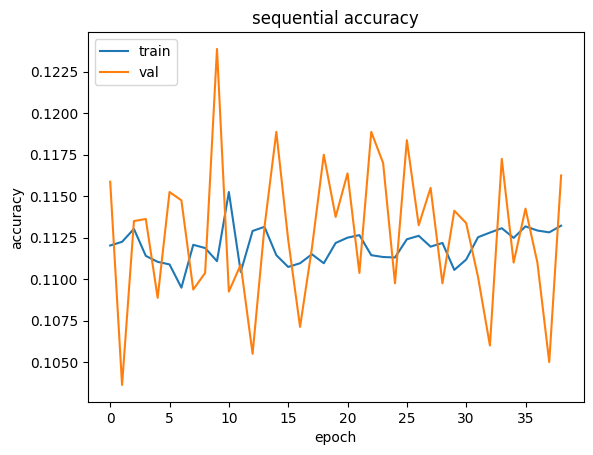

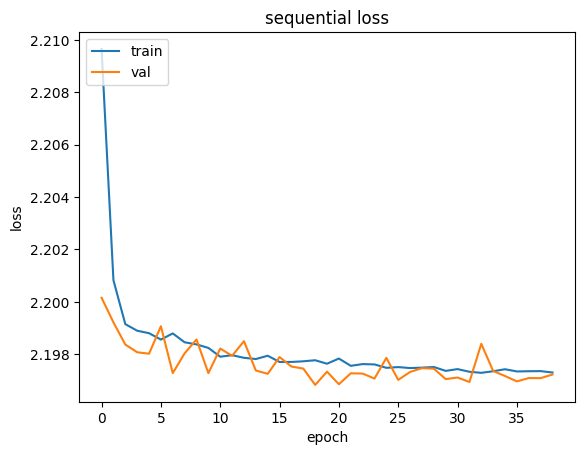

some examples...
Input [6, 0, 0, 1] Expected: [1, 0, 0, 6] Predicted [7, 7, 7, 7]  False
Input [0, 0, 6, 7] Expected: [7, 6, 0, 0] Predicted [7, 7, 7, 7]  False
Input [1, 3, 3, 7] Expected: [7, 3, 3, 1] Predicted [7, 7, 7, 7]  False
Input [8, 6, 5, 3] Expected: [3, 5, 6, 8] Predicted [6, 7, 7, 7]  False
Input [7, 1, 5, 5] Expected: [5, 5, 1, 7] Predicted [7, 7, 7, 7]  False
Input [6, 1, 4, 3] Expected: [3, 4, 1, 6] Predicted [7, 7, 7, 7]  False
Input [4, 5, 4, 1] Expected: [1, 4, 5, 4] Predicted [7, 7, 7, 7]  False
Input [8, 4, 5, 0] Expected: [0, 5, 4, 8] Predicted [6, 7, 7, 7]  False
Input [1, 1, 2, 8] Expected: [8, 2, 1, 1] Predicted [7, 7, 3, 6]  False
Input [3, 1, 3, 5] Expected: [5, 3, 1, 3] Predicted [7, 7, 7, 7]  False


In [22]:
train_test(mlp, X_train, y_train , X_test, y_test, verbose=2)

In [37]:
mlp.weights

[<KerasVariable shape=(10, 256), dtype=float32, path=sequential/dense/kernel>,
 <KerasVariable shape=(256,), dtype=float32, path=sequential/dense/bias>,
 <KerasVariable shape=(256, 128), dtype=float32, path=sequential/dense_1/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=sequential/dense_1/bias>,
 <KerasVariable shape=(128, 64), dtype=float32, path=sequential/dense_2/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential/dense_2/bias>,
 <KerasVariable shape=(64, 10), dtype=float32, path=sequential/dense_3/kernel>,
 <KerasVariable shape=(10,), dtype=float32, path=sequential/dense_3/bias>]

In [38]:
mlp.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1005 - loss: 2.1973 


[2.1978847980499268, 0.10625000298023224]

Need to use LSTM RNN or other

In [39]:
# using lstm , rnn in other notebook